# 필요한 모듈 불러오기

In [2]:
import copy, cv2
import tensorflow          as tf
import numpy               as np
import matplotlib.pyplot   as plt
import tensorflow_datasets as tfds

from PIL        import Image
from tensorflow import keras

<div style = "height: 50px;"><div/>

# <span style = "font-weight:bold;color:#0172d4;">STEP 1</span> : 데이터 준비하기

## 1. 데이터 불러오기
<hr/>

In [4]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                         split=['train', 'test'],
                                         shuffle_files=True,
                                         with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteCYNMIV/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteCYNMIV/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


<div style = "height: 25px;"></div>

### train 

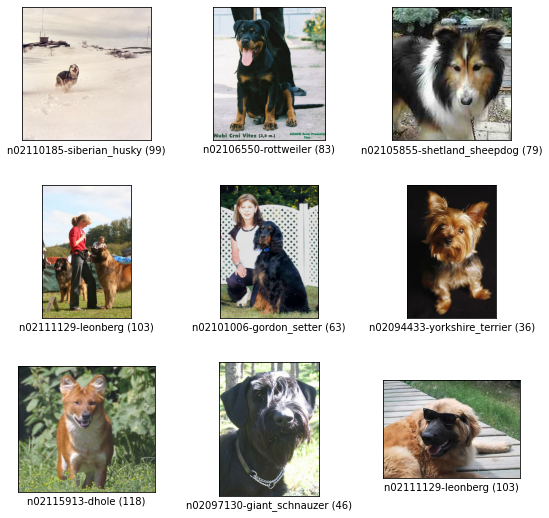

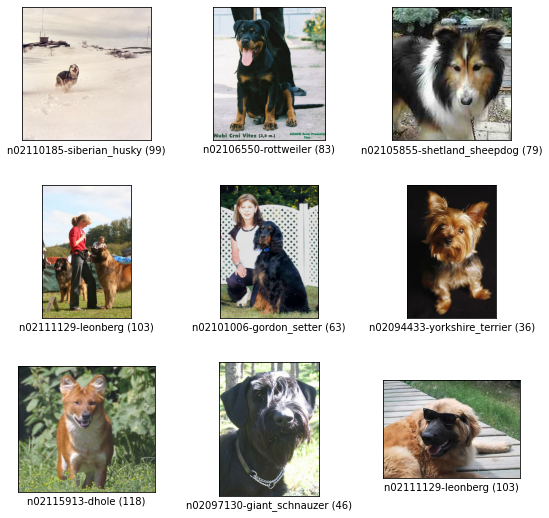

In [5]:
tfds.show_examples(ds_train, ds_info)

<div style = "height: 25px;"></div>

### test 

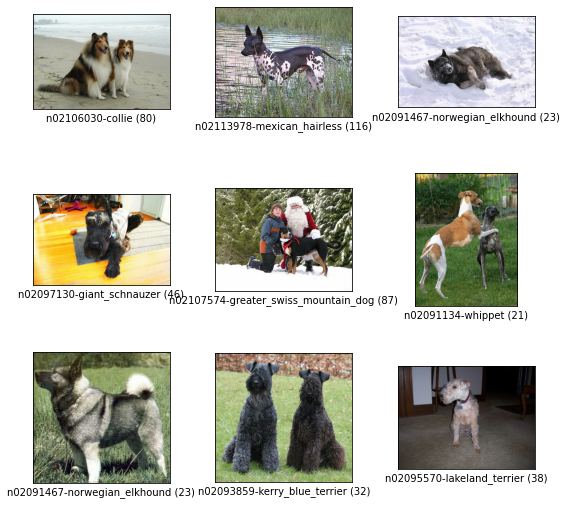

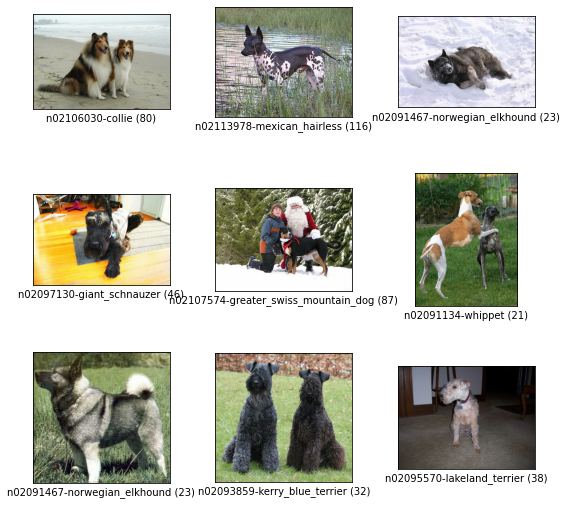

In [6]:
tfds.show_examples(ds_test, ds_info)

<div style = "height: 25px;"></div>

### ds_info 확인하기

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

<div style = "height: 50px;"><div/>

# <span style = "font-weight:bold;color:#0172d4;">STEP 2</span> : 모델 준비하기

## 1. ResNet50 모델 불러오기
<hr/>

In [8]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(include_top = False,     # Imagenet 분류기  fully connected layer 제거
                                                  weights     = 'imagenet',
                                                  input_shape = (224, 224,3),
                                                  pooling     = 'avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


### 파라미터 설명

<ul style = "font-size:15px;">
    <li style = "margin-bottom:20px;"><span style = "font-weight:bold;color:#0172d4;">include_top</span> : False를 함으로써 Imagenet 분류기  fully connected layer를 제거함</li>
    <li style = "margin-bottom:20px;"><span style = "font-weight:bold;color:#0172d4;">weights</span> : 가중치를 뜻하며 imagenet에서 이미지를 분류하는 모델의 가중치를 불러옴</li>
    <li style = "margin-bottom:20px;"><span style = "font-weight:bold;color:#0172d4;">pooling</span> : avg를 지정하여 GAP을 적용할 수 있다.</li>
</ul>

<div style = "height: 50px;"><div/>

# <span style = "font-weight:bold;color:#0172d4;">STEP 3</span> : 데이터셋 조정하여 다시 불러오기

In [9]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

In [10]:
def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16):
    ds = ds.map(normalize_and_resize_img,
               num_parallel_calls = 2)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm  = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


<div style = "height: 50px;"><div/>

# <span style = "font-weight:bold;color:#0172d4;">STEP 4</span> : Grad-CAM, CAM용모델 학습하기 - Plain (LMS)

## 1. 모델 학습하기
<hr/>

In [12]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate= 0.01),
    metrics=['accuracy'],
)

In [13]:
history_cam_model = cam_model.fit(ds_train_norm,
                                  steps_per_epoch     = int(ds_info.splits['train'].num_examples / 16),
                                  validation_steps    = int(ds_info.splits['test'].num_examples / 16),
                                  epochs              = 2,
                                  validation_data     = ds_test_norm,
                                  verbose             = 1,
                                  use_multiprocessing = True,
)

Epoch 1/2
750/750 [==============================] - 107s 120ms/step - loss: 2.1836 - accuracy: 0.4526 - val_loss: 2.8836 - val_accuracy: 0.2842
Epoch 2/2
750/750 [==============================] - 89s 118ms/step - loss: 0.6719 - accuracy: 0.8183 - val_loss: 0.9851 - val_accuracy: 0.7119


In [16]:
# 모델 저장
cam_model_path = '/content/drive/MyDrive/00.AIFFEL/02.Going Deeper/10. 나를 찾아줘 - Class Activation Map 만들기/cam_model_3.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


<div style = "height: 50px;"></div>

## 2. 학습 시각화
<hr/>

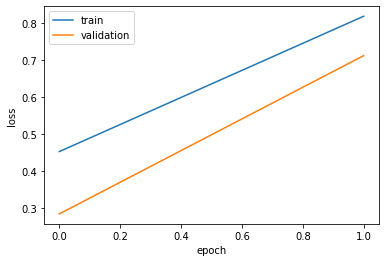

In [14]:
plt.plot(history_cam_model.history['accuracy'], label ='train')
plt.plot(history_cam_model.history['val_accuracy'], label ='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

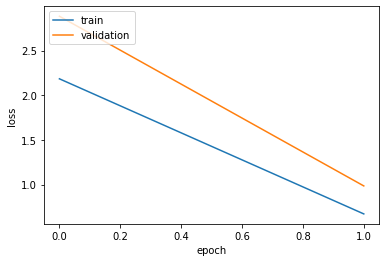

In [15]:
plt.plot(history_cam_model.history['loss'], label ='train')
plt.plot(history_cam_model.history['val_loss'], label ='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

<div style = "height: 50px;"><div/>

# <span style = "font-weight:bold;color:#0172d4;">STEP 5</span> : CAM 구현하기

In [17]:
# 데이터셋에서 한 장씩 뽑는 함수 
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

80


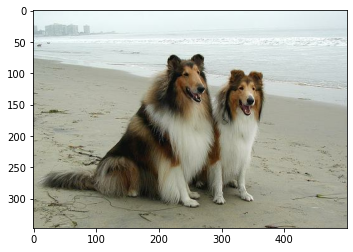

In [18]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [19]:
# 모델 불러오기
cam_model_path = '/content/drive/MyDrive/00.AIFFEL/02.Going Deeper/10. 나를 찾아줘 - Class Activation Map 만들기/cam_model_3.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

<div style = "height: 50px;"><div/>

## CAM 구현

In [20]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

<div style = "height: 50px;"><div/>

## CAM 확인
<hr/>

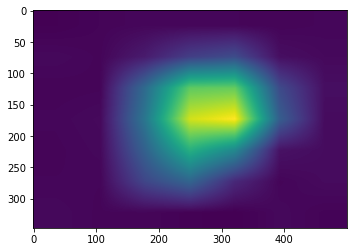

In [21]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

<div style = "height: 50px;"><div/>

## CAM 이미지 합성

In [22]:
# 그려진 CAM 이미지를 원본 이미지와 합침
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

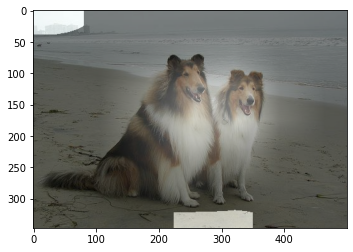

In [23]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

<div style = "height: 50px;"><div/>

# <span style = "font-weight:bold;color:#0172d4;">STEP 6</span> : Grad-CAM 구현하기

80


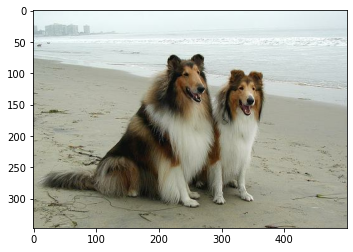

In [24]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

<div style = "height: 50px;"><div/>

## Grad-CAM 구현
<hr/>

In [25]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

<div style = "height: 50px;"><div/>

## 레이어별 CAM 확인
<hr/>

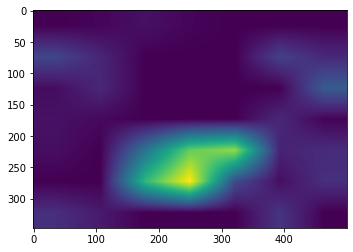

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

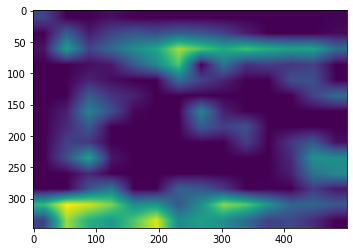

In [27]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

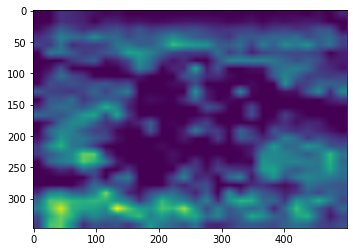

In [28]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

<div style = "height: 50px;"><div/>

# <span style = "font-weight:bold;color:#0172d4;">STEP 7</span> : 바운딩 박스 구하기

80


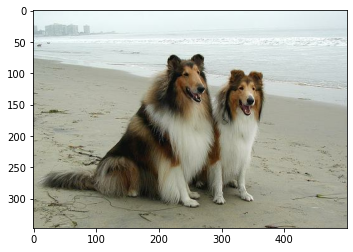

In [29]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

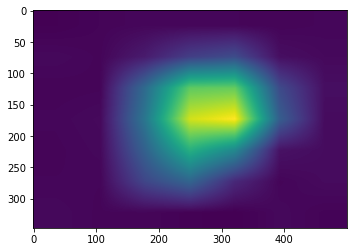

In [30]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [31]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [32]:
rect = get_bbox(cam_image)
rect

array([[108,  43],
       [450,  29],
       [461, 303],
       [119, 317]])

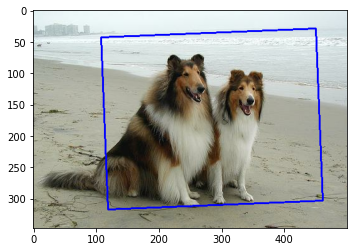

In [33]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

<div style = "height: 50px;"><div/>

# <span style = "font-weight:bold;color:#0172d4;">STEP 8</span> : IoU 구하기

In [34]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [35]:
# rect를 minmax bbox 형태로 치환
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.08357348703170028, 0.216, 0.9135446685878963, 0.922]

In [36]:
# ground truth bbox를 확인
item['objects']['bbox']

array([[0.19596542, 0.02      , 0.9048991 , 0.578     ],
       [0.26224783, 0.584     , 0.89048994, 0.736     ]], dtype=float32)

In [37]:
#  IoU를 계산 및 확인
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [38]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.3540215626424405

<div style = "height: 50px;"><div/>

# <span style = "font-weight:bold;color:#0172d4;">STEP 9</span> : 모델 다르게 학습해보기

 <ul style = "font-size:15px;">
    <li style = "margin-bottom:10px;"><span style = "font-weight:bold;color:#0172d4;">learning_rate</span> : 0.01</li>
    <li style = "margin-bottom:10px;"><span style = "font-weight:bold;color:#0172d4;">batch_size</span> : 16</li>
    <li style = "margin-bottom:10px;"><span style = "font-weight:bold;color:#0172d4;">optimizer</span> : SGD</li>
    <li style = "margin-bottom:10px;"><span style = "font-weight:bold;color:#0172d4;">epochs</span> : 50</li>
</ul>

## 1. 데이터 불러오기
<hr/>

In [10]:
def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16):
    ds = ds.map(normalize_and_resize_img,
               num_parallel_calls = 2)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [11]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm  = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


<div style = "height: 50px;"><div/>

## 2. 모델 준비
<hr/>

In [8]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(include_top=False,     # Imagenet 분류기  fully connected layer 제거
                                           def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16):
    ds = ds.map(normalize_and_resize_img,
               num_parallel_calls = 2)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds       weights='imagenet',
                                                  input_shape=(224, 224,3),
                                                  pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 1s 0us/step


In [12]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate= 0.01),
    metrics=['accuracy'],
)

<div style = "height: 50px;"><div/>

## 3. 모델 훈련
<hr/>

In [13]:
history_cam_model = cam_model.fit(ds_train_norm,
                                  steps_per_epoch     = int(ds_info.splits['train'].num_examples / 16),
                                  validation_steps    = int(ds_info.splits['test'].num_examples / 16),
                                  epochs              = 50,
                                  validation_data     = ds_test_norm,
                                  verbose             = 1,
                                  use_multiprocessing = True,
)

Epoch 1/50
750/750 [==============================] - 113s 125ms/step - loss: 2.2074 - accuracy: 0.4482 - val_loss: 3.2972 - val_accuracy: 0.2277
Epoch 2/50
750/750 [==============================] - 92s 122ms/step - loss: 0.6762 - accuracy: 0.8168 - val_loss: 1.0978 - val_accuracy: 0.6838
Epoch 3/50
750/750 [==============================] - 92s 122ms/step - loss: 0.1881 - accuracy: 0.9659 - val_loss: 0.9457 - val_accuracy: 0.7242
Epoch 4/50
750/750 [==============================] - 92s 123ms/step - loss: 0.0513 - accuracy: 0.9969 - val_loss: 0.9168 - val_accuracy: 0.7325
Epoch 5/50
750/750 [==============================] - 92s 122ms/step - loss: 0.0227 - accuracy: 0.9996 - val_loss: 1.0567 - val_accuracy: 0.7018
Epoch 6/50
750/750 [==============================] - 92s 122ms/step - loss: 0.0501 - accuracy: 0.9958 - val_loss: 0.9820 - val_accuracy: 0.7270
Epoch 7/50
750/750 [==============================] - 92s 123ms/step - loss: 0.0164 - accuracy: 0.9992 - val_loss: 0.9276 - val_a

In [16]:
cam_model_path = '/content/drive/MyDrive/00.AIFFEL/02.Going Deeper/10. 나를 찾아줘 - Class Activation Map 만들기/cam_model_4.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


<div style = "height: 50px;"><div/>

## 4. 훈련 결과 시각화
<hr/>

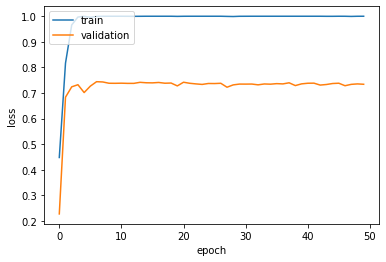

In [14]:
            plt.plot(history_cam_model.history['accuracy'], label ='train')
plt.plot(history_cam_model.history['val_accuracy'], label ='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

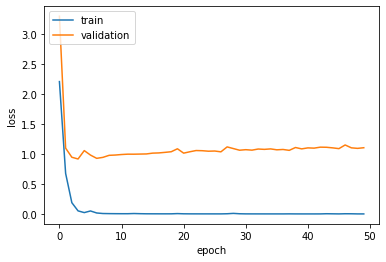

In [15]:
plt.plot(history_cam_model.history['loss'], label ='train')
plt.plot(history_cam_model.history['val_loss'], label ='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

<div style = "height: 50px;"><div/>

## 5. CAM 확인
<hr/>

108


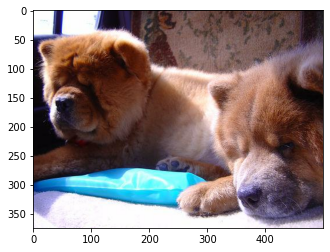

In [18]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [19]:
cam_model_path = '/content/drive/MyDrive/00.AIFFEL/02.Going Deeper/10. 나를 찾아줘 - Class Activation Map 만들기/cam_model_4.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

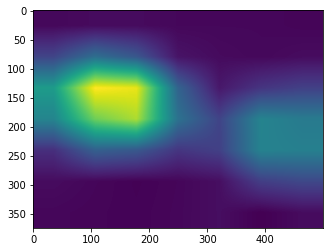

In [21]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

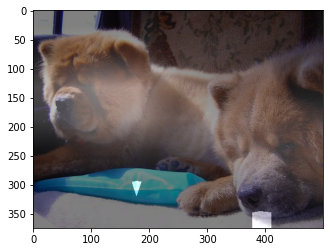

In [23]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

<div style = "height: 50px;"><div/>

## 6. 레이어별 CAM 확인 (Grad-CAM)
<hr/>

67


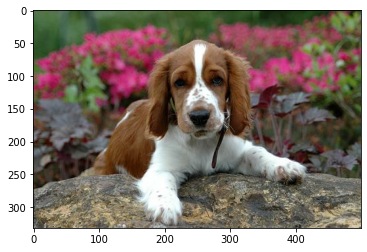

In [39]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

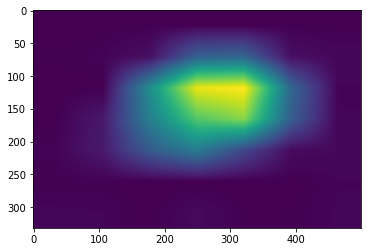

In [41]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

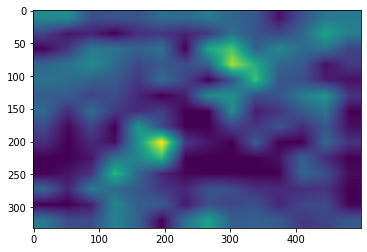

In [42]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

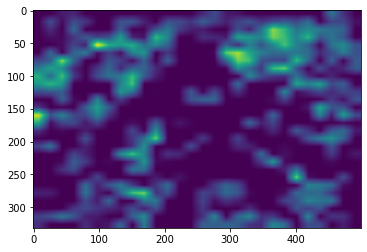

In [43]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

<div style = "height: 50px;"><div/>

## 7. 바운딩 박스 확인
<hr/>

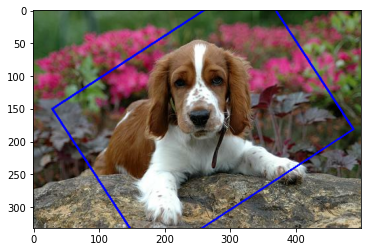

In [59]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

<div style = "height: 50px;"><div/>

## 8. IoU 계산 및 확인
<hr/>

In [64]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.48525376101243506

<div style = "height: 50px;"><div/>

# <span style = "font-weight:bold;color:#0172d4;">STEP 10</span> : 모델 다르게 학습해보기 (2)

 <ul style = "font-size:15px;">
    <li style = "margin-bottom:10px;"><span style = "font-weight:bold;color:#0172d4;">learning_rate</span> : 0.001</li>
    <li style = "margin-bottom:10px;"><span style = "font-weight:bold;color:#0172d4;">batch_size</span> : 32</li>
    <li style = "margin-bottom:10px;"><span style = "font-weight:bold;color:#0172d4;">optimizer</span> : SGD</li>
    <li style = "margin-bottom:10px;"><span style = "font-weight:bold;color:#0172d4;">epochs</span> : 50</li>
</ul>

## 1. 데이터 불러오기
<hr/>

In [ ]:
def apply_normalize_on_dataset(ds, is_test = False, batch_size = 32):
    ds = ds.map(normalize_and_resize_img,
               num_parallel_calls = 2)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm  = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(32, 224, 224, 3)
(32,)


<div style = "height: 50px;"><div/>

## 2. 모델 준비
<hr/>

In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate= 0.001),
    metrics=['accuracy'],
)

<div style = "height: 50px;"><div/>

## 3. 모델 훈련
<hr/>

In [ ]:
history_cam_model = cam_model.fit(ds_train_norm,
                                  steps_per_epoch     = int(ds_info.splits['train'].num_examples / 32),
                                  validation_steps    = int(ds_info.splits['test'].num_examples / 32),
                                  epochs              = 50,
                                  validation_data     = ds_test_norm,
                                  verbose             = 1,
                                  use_multiprocessing = True,
)

Epoch 1/50
375/375 [==============================] - 105s 225ms/step - loss: 4.7961 - accuracy: 0.0299 - val_loss: 5.7126 - val_accuracy: 0.0055
Epoch 2/50
375/375 [==============================] - 81s 216ms/step - loss: 3.8590 - accuracy: 0.1742 - val_loss: 4.5801 - val_accuracy: 0.0531
Epoch 3/50
375/375 [==============================] - 81s 216ms/step - loss: 2.9726 - accuracy: 0.3803 - val_loss: 2.5985 - val_accuracy: 0.3995
Epoch 4/50
375/375 [==============================] - 81s 217ms/step - loss: 2.3303 - accuracy: 0.5228 - val_loss: 2.1041 - val_accuracy: 0.5075
Epoch 5/50
375/375 [==============================] - 81s 217ms/step - loss: 1.8633 - accuracy: 0.6168 - val_loss: 1.8110 - val_accuracy: 0.5564
Epoch 6/50
375/375 [==============================] - 81s 217ms/step - loss: 1.5674 - accuracy: 0.6699 - val_loss: 1.5973 - val_accuracy: 0.6016
Epoch 7/50
375/375 [==============================] - 82s 217ms/step - loss: 1.3271 - accuracy: 0.7115 - val_loss: 1.4618 - val_a

In [ ]:
cam_model_path = '/content/drive/MyDrive/00.AIFFEL/02.Going Deeper/10. 나를 찾아줘 - Class Activation Map 만들기/cam_model_2.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


<div style = "height: 50px;"><div/>

## 4. 훈련 결과 시각화
<hr/>

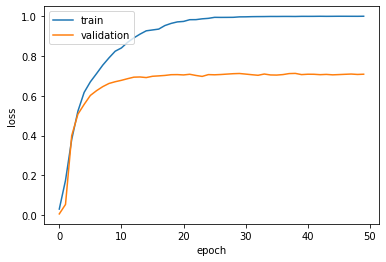

In [ ]:
plt.plot(history_cam_model.history['accuracy'], label ='train')
plt.plot(history_cam_model.history['val_accuracy'], label ='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

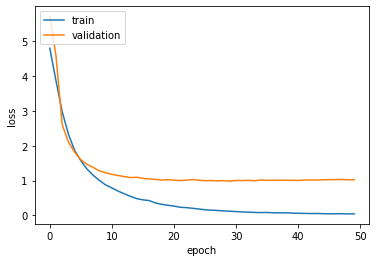

In [ ]:
plt.plot(history_cam_model.history['loss'], label ='train')
plt.plot(history_cam_model.history['val_loss'], label ='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

<div style = "height: 50px;"><div/>

## 5. CAM 확인
<hr/>

108


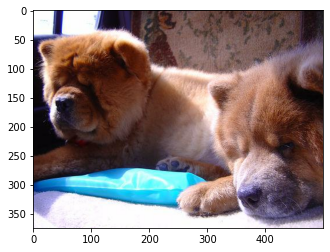

In [108]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [109]:
cam_model_path = '/content/drive/MyDrive/00.AIFFEL/02.Going Deeper/10. 나를 찾아줘 - Class Activation Map 만들기/cam_model_2.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

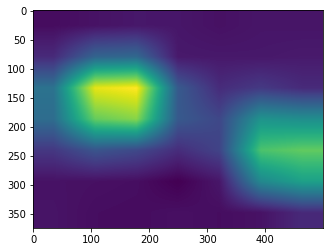

In [111]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

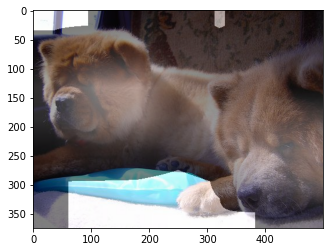

In [113]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

<div style = "height: 50px;"><div/>

## 6. 레이어별 CAM 확인 (Grad-CAM)
<hr/>

67


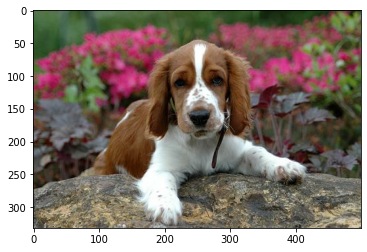

In [114]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

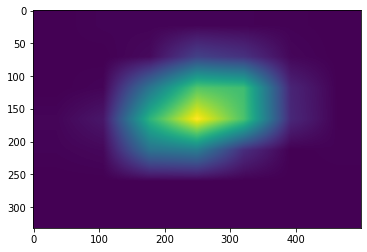

In [116]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

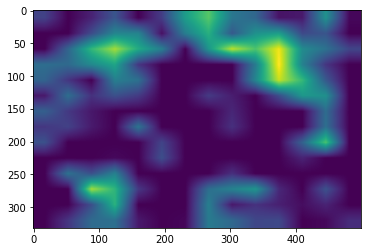

In [117]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

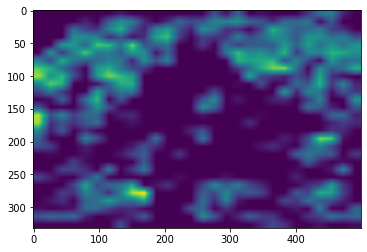

In [118]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

<div style = "height: 50px;"><div/>

## 7. 바운딩 박스 확인
<hr/>

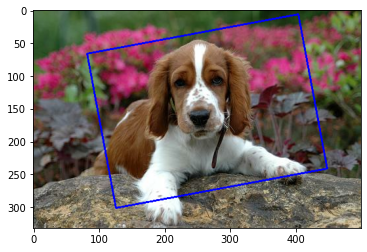

In [123]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

<div style = "height: 50px;"><div/>

## 8. IoU 계산 및 확인
<hr/>

In [128]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.709360892561157

<div style = "height: 50px;"><div/>

# <span style = "font-weight:bold;color:#0172d4;">STEP 11</span> : 결과 분석

## 1. ACCURACY
<hr/>

<img src = "img/acc.png">

<div style = "height: 50px;"><div/>

## LOSS
<hr/>

<img src = "img/loss.png">

<div style = "height: 50px;"><div/>

## IoU
<hr/>

<table style = "width:80%; margin:auto; border:0.5px solid #c1c1c1; font-size:15px;">
    <th style = "width:33.33333%; padding:10px; text-align:center; border:0.5px solid #c1c1c1;">Plain Model</th>
    <th style = "width:33.33333%%; padding:10px; text-align:center; border:0.5px solid #c1c1c1;">Model 2</th>
    <th style = "width:33.33333%%; padding:10px; text-align:center; border:0.5px solid #c1c1c1;">Model 3</th>
    <tr>
        <td style = "padding:10px; text-align:center; border:0.5px solid #c1c1c1;">0.3540</td>
        <td style = "padding:10px; text-align:center; border:0.5px solid #c1c1c1;">0.4852</td>
        <td style = "padding:10px; text-align:center; border:0.5px solid #c1c1c1;">0.7093</td>
    </tr>
</table>

<div style = "height: 50px;"><div/>

# <span style = "font-weight:bold;color:#0172d4;">STEP 12</span> :  회고

이번에는 LMS과정을 그대로 진행하면 되는 프로젝트라서, 모델 학습에 변화를 주고자 하였으나, 전체적으로 loss값이 7점대에서 머무르는 것을 확인할 수 있었다. <br/>
그러나, loss값이 비슷한 것과는 다르게 IOU값은 현저히 다른 것을 확인하였다.<br/>
그런 것과는 다르게 CAM을 확인했을 때에는 이미지가 다 비슷해서 신기했다.

<div style = "height: 50px;"><div/>